## Human Activity Recognition System using Machine Learning techniques for Home Automation by Leon Vitanos

Dataset used: https://tev.fbk.eu/technologies/smartwatch-gestures-dataset

Eight different users performed twenty repetitions of twenty different gestures, for a total of 3200 sequences. Each sequence contains acceleration data from the 3-axis accelerometer of a first generation Sony SmartWatch™, as well as timestamps from the different clock sources available on an Android device. The smartwatch was worn on the user's right wrist. The gestures have been manually segmented by the users performing them by tapping the smartwatch screen at the beginning and at the end of every repetition.

<img src="https://i.imgur.com/U3Uqe9x.png">



### Load and preprocess dataset
We use the first 8 Haar transformation coefficients for each axis, creating a 24 vector for each sequence

In [1]:
import numpy as np
import pandas as pd
import os
import pywt

print("Loading and preprocessing dataset...")
training_data_all_gestures = []
training_data_six_gestures = []
users = ["U01", "U02", "U03", "U04", "U05", "U06", "U07", "U08"]
gestures = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
            "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

def haar_transform(sequence_array):
    x = np.concatenate((pywt.wavedec(sequence_array.iloc[:,0], 'db1', level=3)))
    y = np.concatenate((pywt.wavedec(sequence_array.iloc[:,1], 'db1', level=3)))
    z = np.concatenate((pywt.wavedec(sequence_array.iloc[:,2], 'db1', level=3)))
    xyz = np.concatenate((x[:8],y[:8],z[:8]))
    return xyz

for user in users:
    user_path = os.path.join("gestures-dataset", user)
    for gesture in gestures:
        class_num = gestures.index(gesture)
        path = os.path.join(user_path, gesture)
        for sequence in os.listdir(path):
            sequence_array = pd.read_csv(os.path.join(path, sequence), sep=" ", header=None, usecols=[3, 4, 5])
            training_data_all_gestures.append([haar_transform(sequence_array),class_num])
            if class_num<=5:
                training_data_six_gestures.append([haar_transform(sequence_array),class_num])
                                
print("In total", len(training_data_all_gestures), "sequences have been loaded and preprocessed")

Loading and preprocessing dataset...
In total 3251 sequences have been loaded and preprocessed


### Split training/validation/test set

In [2]:
#For all gestures
X, y = [], []

for features, label in training_data_all_gestures:
    X.append(features)
    y.append(label)
    
X_train, X_test, y_train, y_test = X[:2449], X[2450:], y[:2449], y[2450:]

#For only the first 6 gestures
X6, y6 = [], []

for features, label in training_data_six_gestures:
    X6.append(features)
    y6.append(label)

X6_train, X6_test, y6_train, y6_test = X6[:735], X6[736:], y6[:735], y6[736:]

#Split train/test/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X6_train, X6_val, y6_train, y6_val = train_test_split(X6_train, y6_train, test_size=0.2, random_state=1)

## Find best algorithm
Between the following:
- K-nearest neighbors (KNN) 
- Decision Tree (DT)
- Random Forest (RF)
- Support Vector Machines (SVM)
- Multilayer perceptron (MLP)
- Convolutional neural network (CNN)
- Recurrent neural networks (RNN) using long-short term memory (LSTM)

### Helper functions, to predict and print results

In [3]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_accuracy, best_accuracy6 = [], []

def predict_accuracy_and_f1():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accTest.append(acc)
    f1 = metrics.f1_score(y_test, y_pred, average="macro", labels=np.unique(y_pred))
    f1Test.append(f1)
        
    model6.fit(X6_train, y6_train)
    y_pred = model6.predict(X6_test)
    acc = metrics.accuracy_score(y6_test, y_pred)
    accTest6.append(acc)
    f1 = metrics.f1_score(y6_test, y_pred, average="macro", labels=np.unique(y_pred))
    f1Test6.append(f1)
       
def print_and_plot_results(model, argument):  
    plt.figure(figsize=(14,6))
    
    plt.subplot(2, 2, 1)
    plt.plot(lnS,f1Test6, label="Using the first 6 gestures")
    plt.plot(lnS,f1Test, label="Using all gestures")
    plt.title("F1 Macro")
    plt.ylabel("F1 Macro")
    plt.xlabel(argument)
    plt.legend(loc='lower right')
    
    plt.subplot(2, 2, 3)
    plt.plot(lnS,accTest6, label="Using the first 6 gestures")
    plt.plot(lnS,accTest, label="Using all gestures")
    plt.title("Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel(argument)
    plt.legend(loc='lower right')
    
    plt.subplot(1, 2, 2)
    y_pred = model.predict(X6_test)
    cm = confusion_matrix(y6_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(
        cm, index=range(1, 7), columns=range(1, 7), 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f")
    except ValueError:
        raise ValueError("Confusion matrix values must be float.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix using 6 gestures\n and %s set to %d " % (argument,accTest6.index(max(accTest6))+1))
    
    plt.tight_layout(pad=0.4, w_pad=3, h_pad=1)
    plt.show()  
    
    max_acc = max(accTest)
    max_acc6 = max(accTest6)
    
    best_accuracy.append(max_acc)
    best_accuracy6.append(max_acc6)
    
    best_acc_index = accTest.index(max_acc)
    best_acc6_index = accTest6.index(max_acc6)
    
    print("Max accuracy is {:.3f},".format(max_acc),"with F1 score {:.3f},".format(f1Test[best_acc_index]),
      "using all gestures and",argument,"set to",best_acc_index+1,end=".\n")
    print("Max accuracy is {:.3f},".format(max_acc6),"with F1 score {:.3f},".format(f1Test6[best_acc_index]),
      "using all gestures and",argument,"set to",best_acc6_index+1,end=".")

### K-nearest neighbors (KNN)

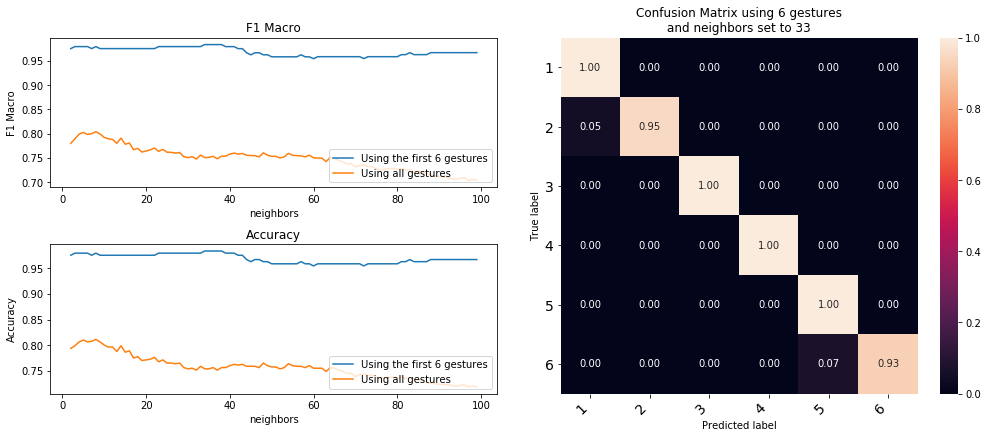

Max accuracy is 0.811, with F1 score 0.804, using all gestures and neighbors set to 7.
Max accuracy is 0.983, with F1 score 0.979, using all gestures and neighbors set to 33.

In [4]:
from sklearn.neighbors import KNeighborsClassifier

accTest, accTest6, f1Test, f1Test6, lnS = ([] for i in range(5))

for ln in range(2,100):
    lnS.append(ln)
    model = KNeighborsClassifier(n_neighbors=ln, weights='distance')
    model6 = KNeighborsClassifier(n_neighbors=ln, weights='distance')
    predict_accuracy_and_f1()

model = KNeighborsClassifier(n_neighbors=accTest6.index(max(accTest6))+1, weights='distance')
model.fit(X6_train, y6_train)
print_and_plot_results(model,"neighbors")

### Decision Tree (DT)

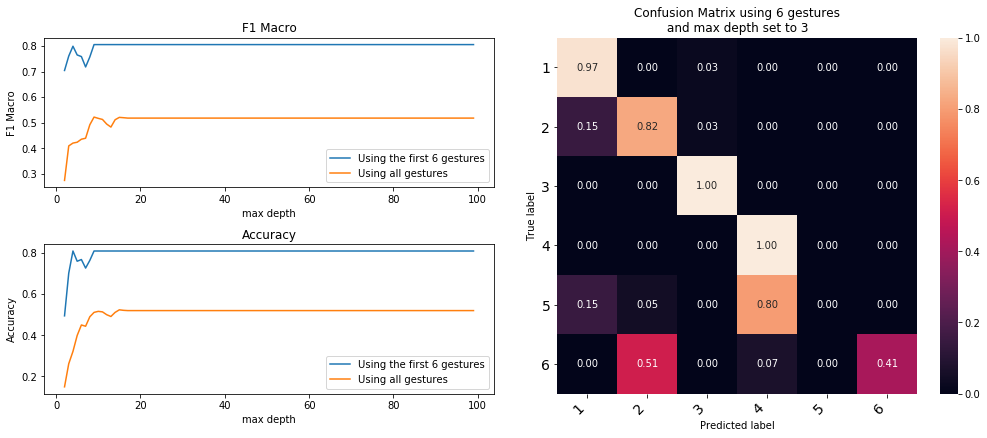

Max accuracy is 0.523, with F1 score 0.521, using all gestures and max depth set to 14.
Max accuracy is 0.809, with F1 score 0.805, using all gestures and max depth set to 3.

In [5]:
from sklearn.tree import DecisionTreeClassifier

accTest, accTest6, f1Test, f1Test6, lnS = ([] for i in range(5))

for ln in range(2,100):
    lnS.append(ln)
    model = DecisionTreeClassifier(max_depth=ln, random_state=0)
    model6 = DecisionTreeClassifier(max_depth=ln, random_state=0)
    predict_accuracy_and_f1()

model = DecisionTreeClassifier(max_depth=accTest6.index(max(accTest6))+1, random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"max depth")

### Random Forest (RF)

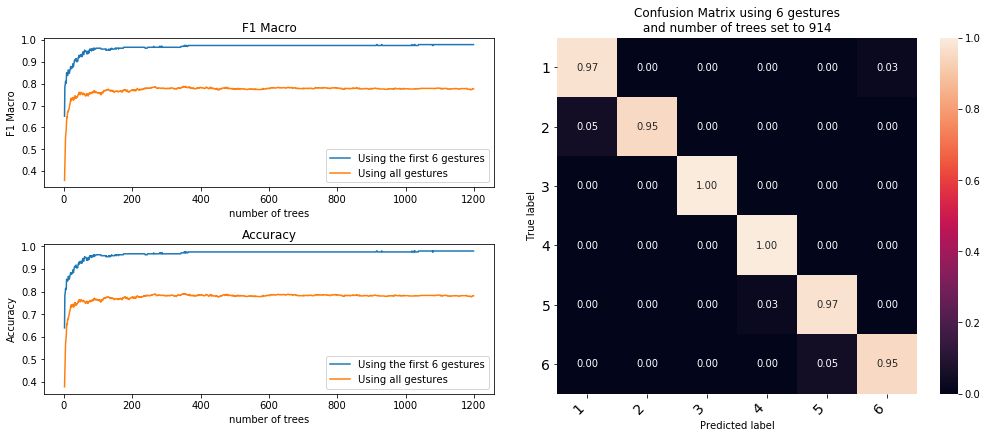

Max accuracy is 0.790, with F1 score 0.788, using all gestures and number of trees set to 349.
Max accuracy is 0.979, with F1 score 0.971, using all gestures and number of trees set to 914.

In [6]:
from sklearn.ensemble import RandomForestClassifier

accTest, accTest6, f1Test, f1Test6, lnS = ([] for i in range(5))

for ln in range(2,1200):
    lnS.append(ln)
    model = RandomForestClassifier(n_estimators=ln, random_state=0)
    model6 = RandomForestClassifier(n_estimators=ln, random_state=0)
    predict_accuracy_and_f1()

model = RandomForestClassifier(n_estimators=accTest6.index(max(accTest6))+1, random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"number of trees")

### Support Vector Machines (SVM)

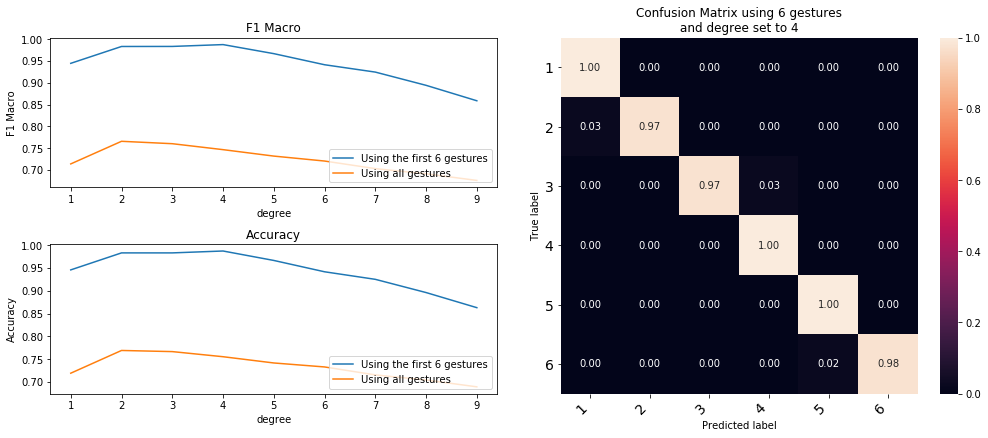

Max accuracy is 0.769, with F1 score 0.766, using all gestures and degree set to 2.
Max accuracy is 0.988, with F1 score 0.983, using all gestures and degree set to 4.

In [7]:
from sklearn.svm import SVC

accTest, accTest6, f1Test, f1Test6, lnS = ([] for i in range(5))

for ln in range(1,10):
    lnS.append(ln)
    model = SVC(kernel='poly', gamma='scale', degree=ln, random_state=0)
    model6 = SVC(kernel='poly', gamma='scale', degree=ln, random_state=0)
    predict_accuracy_and_f1()

model = SVC(kernel='poly', gamma='scale', degree=accTest6.index(max(accTest6))+1, random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"degree")

## Deep Learning

In [8]:
# Obtain reproducidle results
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

CUDA_VISIBLE_DEVICES=""
PYTHONHASHSEED=0
import random as rn
import tensorflow as tf
from keras import backend as K
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Print and plot Results
def print_and_plot_results_neural_network(acc, acc6, history, history6):  
    plt.plot(history.history['val_acc'], label='Using all gestures')
    plt.plot(history6.history['val_acc'], label='Using 6 gestures')
    plt.legend()
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.show()
    
    best_accuracy.append(acc)
    best_accuracy6.append(acc6)
    
    print("Accuracy score is {:.3f},".format(acc), "using all gestures",end=".\n")
    print("Accuracy score is {:.3f},".format(acc6), "using 6 gestures",end=".")
    
#Convert data lists to np arrays
x_tr, y_tr, x_te, y_te,  = np.asarray(X_train),np.asarray(y_train), np.asarray(X_test), np.asarray(y_test)
x_val, y_val, x6_tr, y6_tr = np.asarray(X_val), np.asarray(y_val), np.asarray(X6_train), np.asarray(y6_train)
x6_te,y6_te, x6_val,y6_val = np.asarray(X6_test), np.asarray(y6_test), np.asarray(X6_val), np.asarray(y6_val)

#Reshaped data, for convolution and lstm
x_tr_conv = x_tr.reshape(x_tr.shape + (1,))
y_tr_conv = y_tr.reshape(y_tr.shape + (1,))
x_te_conv = x_te.reshape(x_te.shape + (1,))
y_te_conv = y_te.reshape(y_te.shape + (1,))
x6_tr_conv = x6_tr.reshape(x6_tr.shape + (1,))
y6_tr_conv = y6_tr.reshape(y6_tr.shape + (1,))
x6_te_conv = x6_te.reshape(x6_te.shape + (1,))
y6_te_conv = y6_te.reshape(y6_te.shape + (1,))

Using TensorFlow backend.


### Multilayer perceptron (MLP)

Using Sklearn's MLPClassifier


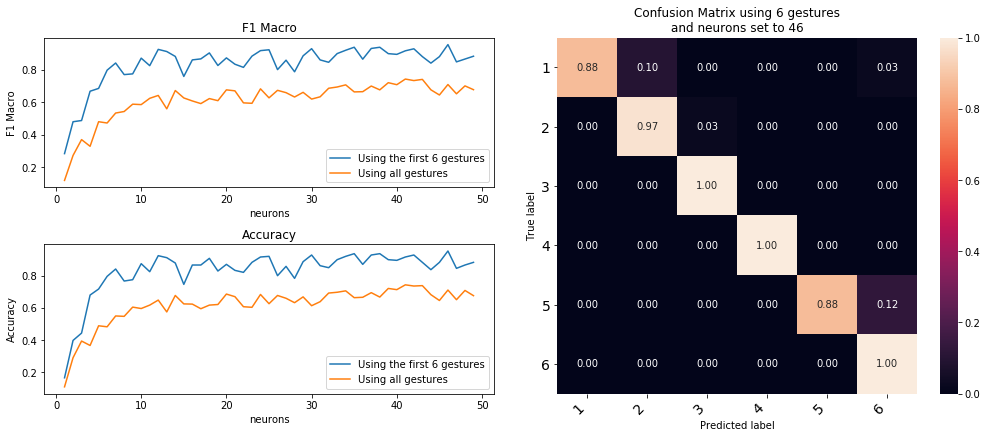

Max accuracy is 0.744, with F1 score 0.743, using all gestures and neurons set to 41.
Max accuracy is 0.954, with F1 score 0.916, using all gestures and neurons set to 46.

In [9]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print("Using Sklearn's MLPClassifier")

accTest, accTest6, f1Test, f1Test6, lnS = ([] for i in range(5))

for ln in range(1,50):
    lnS.append(ln)
    model = MLPClassifier(hidden_layer_sizes=(ln,), solver='adam', random_state=0)
    model6 = MLPClassifier(hidden_layer_sizes=(ln,), solver='adam', random_state=0)
    predict_accuracy_and_f1()

model = MLPClassifier(hidden_layer_sizes=(accTest6.index(max(accTest6))+1,), solver='adam', random_state=0)
model.fit(X6_train, y6_train)
print_and_plot_results(model,"neurons")

Epoch 00739: early stopping
801/801 [==============================] - 0s 9us/step
Epoch 00178: early stopping
241/241 [==============================] - 0s 12us/step


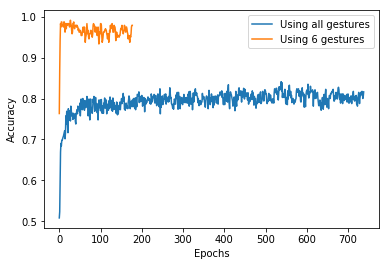

Accuracy score is 0.816, using all gestures.
Accuracy score is 0.979, using 6 gestures.

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
from keras.callbacks import EarlyStopping

np.random.seed(53)

def create_mlp_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=24))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax'))
    model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#For all gestures
model = create_mlp_model()
history = model.fit(x_tr, y_tr, validation_data=(x_te, y_te), epochs=1000,
                    callbacks=[EarlyStopping(monitor='val_acc', patience=200, verbose=1)], 
                    batch_size=128,  verbose=0)
_, test_acc = model.evaluate(x_te, y_te, batch_size=128)

#For 6 gestures
model6 = create_mlp_model()
history6 = model6.fit(x6_tr, y6_tr, validation_data=(x6_te, y6_te), epochs=1000,
                      callbacks=[EarlyStopping(monitor='val_acc', patience=150, verbose=1)],
                      batch_size=128, verbose=0)
_, test_acc6 = model6.evaluate(x6_te, y6_te, batch_size=128)

print_and_plot_results_neural_network(test_acc, test_acc6, history, history6)

### Convolutional neural network (CNN)

Epoch 00323: early stopping
801/801 [==============================] - 0s 27us/step
Epoch 00349: early stopping
241/241 [==============================] - 0s 29us/step


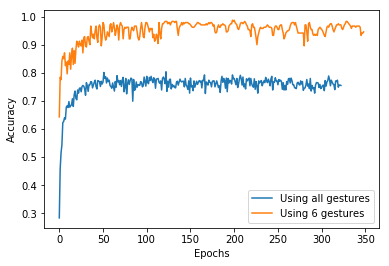

Accuracy score is 0.755, using all gestures.
Accuracy score is 0.946, using 6 gestures.

In [11]:
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

np.random.seed(52)

def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(24, 1)))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#For all gestures
model = create_cnn_model()
history = model.fit(x_tr_conv, y_tr_conv, validation_data=(x_te_conv, y_te_conv), 
                    callbacks=[EarlyStopping(monitor='val_acc', patience=200, verbose=1)],
                    batch_size=128, epochs=1000, verbose=0)
_, test_acc = model.evaluate(x_te_conv, y_te_conv, batch_size=128)

#For 6 gestures
model6 = create_cnn_model()
history6 = model6.fit(x6_tr_conv, y6_tr_conv, validation_data=(x6_te_conv, y6_te_conv), 
                     callbacks=[EarlyStopping(monitor='val_acc', patience=150, verbose=1)],
                     batch_size=128, epochs=1000, verbose=0)
_, test_acc6 = model6.evaluate(x6_te_conv, y6_te_conv, batch_size=128)

print_and_plot_results_neural_network(test_acc, test_acc6, history, history6)

### Recurrent neural networks (RNN) using long-short term memory (LSTM)

Epoch 00171: early stopping
800/800 [==============================] - 0s 207us/step
Epoch 00108: early stopping
224/224 [==============================] - 0s 218us/step


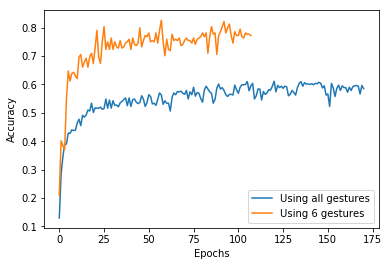

Accuracy score is 0.583, using all gestures.
Accuracy score is 0.772, using 6 gestures.

In [12]:
from keras.layers import LSTM

np.random.seed(53)

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, stateful=True,
                   batch_input_shape=(batch_size, 24, 1)))
    model.add(LSTM(64, return_sequences=True, stateful=True))
    model.add(LSTM(64, stateful=True))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
    return model

#In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size.
batch_size = 32

#For all gestures
model = create_lstm_model()
history = model.fit(x_tr_conv[:1952], y_tr_conv[:1952],
                    validation_data=(x_te_conv[:800], y_te_conv[:800]),
                    callbacks=[EarlyStopping(monitor='val_acc', patience=50, verbose=1)],
                    batch_size=batch_size, epochs=1000,verbose=0)
_, test_acc = model.evaluate(x_te_conv[:800], y_te_conv[:800], batch_size=batch_size)

#For 6 gestures
model6 = create_lstm_model()
history6 = model6.fit(x6_tr_conv[:576], y6_tr_conv[:576],
                    validation_data=(x6_te_conv[:224], y6_te_conv[:224]),
                    callbacks=[EarlyStopping(monitor='val_acc', patience=50, verbose=1)],
                    batch_size=batch_size, epochs=1000,verbose=0)
_, test_acc6 = model6.evaluate(x6_te_conv[:224], y6_te_conv[:224], batch_size=batch_size)

print_and_plot_results_neural_network(test_acc, test_acc6, history, history6)

### Print accuracies for every algorithm

In [13]:
algorithms = ['KNN', 'DT', 'RF', 'SVM', 'Sklearn-MLP', 'MLP', 'CNN', 'RNN/LSTM']

print('%-13s%-17s%s' % ('', 'All gestures', '6 gestures'))
for i, (algorithm, accuracy, accuracy6) in enumerate(zip(algorithms, best_accuracy, best_accuracy6)):
    accuracy = format(accuracy*100, '.2f')
    accuracy6 = format(accuracy6*100, '.2f')
    accuracy = accuracy + '%'
    accuracy6 = accuracy6 + '%'
    
    if i == best_accuracy.index(max(best_accuracy)):
        accuracy = '\033[1m' + str(accuracy) + '\033[0m\t\t'
    if i == best_accuracy6.index(max(best_accuracy6)):
        accuracy6 = '\033[1m' + str(accuracy6) + '\033[0m'
        
    print('%-16s%-16s%s' % (algorithm, accuracy, accuracy6))

             All gestures     6 gestures
KNN             81.15%          98.34%
DT              52.31%          80.91%
RF              79.03%          97.93%
SVM             76.90%          98.76%
Sklearn-MLP     74.41%          95.44%
MLP             81.65%		97.93%
CNN             75.53%          94.61%
RNN/LSTM        58.25%          77.23%
